YIELD OPTIMIZATION ANALYSIS
Temperature range: 350-440°C (safety limit)
Volume range: 0-50.0 m³


/tmp/ipython-input-4240981407.py:120: RuntimeWarning: invalid value encountered in divide
  S = np.where(F_B0 - F_B != 0, F_MA / (F_B0 - F_B), 0)



✅ FEASIBLE OPTIMAL SOLUTION FOUND

GLOBAL OPTIMUM:
  Temperature:      395.0 °C
  Reactor Volume:   50.00 m³
  Conversion (X):   0.8085
  Selectivity (S):  0.6916
  Yield (Y = X×S):  0.5591
  MA Flow Rate:     6.710 mol/s
  Annual Production: 193.24 kt/year

CONSTRAINT CHECK:
  T ≤ 440°C: ✅ (395.0°C)
  V ≤ 50.0 m³: ✅ (50.00 m³)
  S ≥ 0.4: ✅ (0.6916)
  X ≥ 0.7: ✅ (0.8085)
  Solution feasible: ✅


/tmp/ipython-input-4240981407.py:263: RuntimeWarning: invalid value encountered in divide
  S = np.where(F_B0 - F_B != 0, F_MA / (F_B0 - F_B), 0)


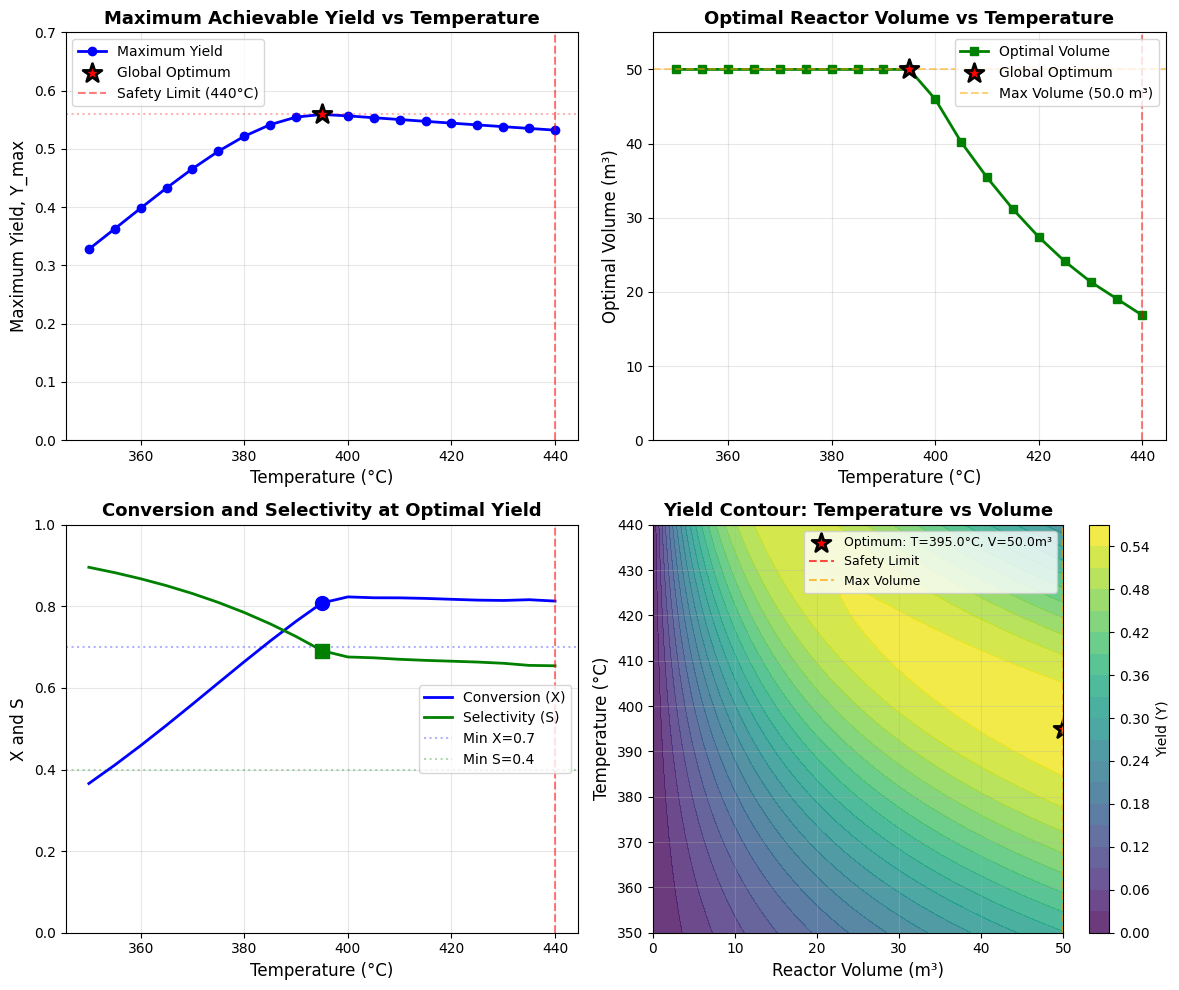


DETAILED ANALYSIS AT OPTIMAL POINT

Yield Profile Analysis:
  Maximum yield: 0.5598
  95% of max yield: 0.5318
  Volume range for Y ≥ 95% max: 37.3 to 60.0 m³ (range: 22.7 m³)
  Optimal volume: 50.0 m³ (within 95% range: Yes)


/tmp/ipython-input-4240981407.py:308: RuntimeWarning: divide by zero encountered in divide
  S_detail = np.where(F_B0 - F_B_detail != 0, F_MA_detail / (F_B0 - F_B_detail), 0)


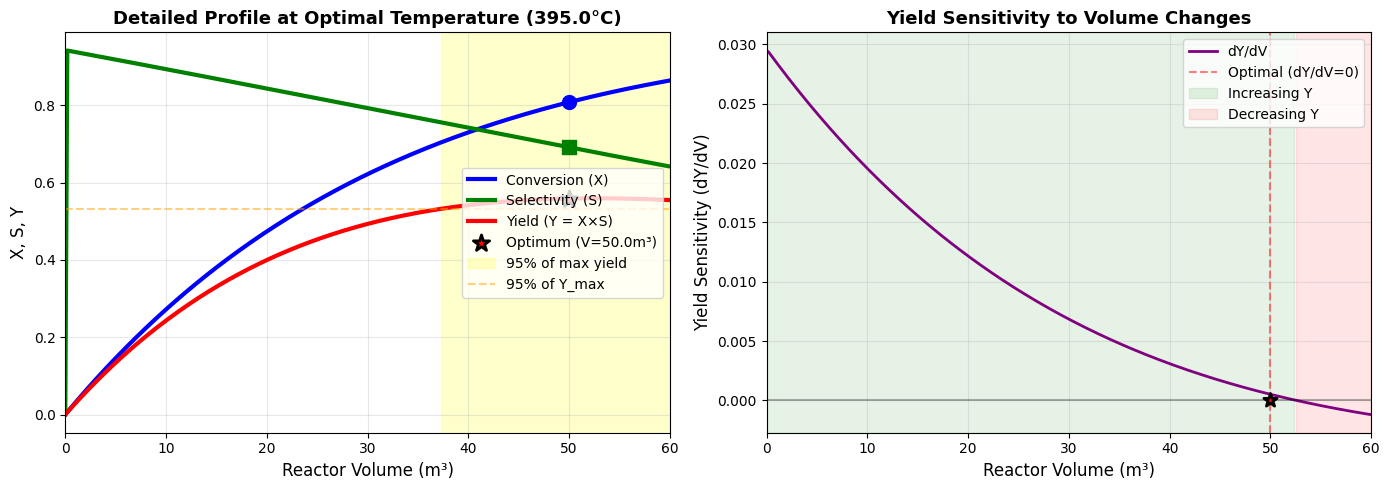


ECONOMIC & TECHNICAL IMPLICATIONS
1. Production Metrics:
   - MA Production: 193.24 kt/year
   - Butane Feed: 20.09 kt/year
   - Butane Consumed: 16.24 kt/year
   - Butane Utilization: 80.8%

2. Reactor Design:
   - Volume: 50.0 m³ (≤ 50.0 m³: OK)
   - Temperature: 395.0°C (≤ 440°C: Safe)

3. Process Efficiency:
   - Overall Yield: 55.9%
   - Selectivity: 69.2%
   - Byproduct generation: 30.8% of reacted butane

4. Sensitivity Analysis:
   - At optimal point, yield increases with volume up to 50.0 m³
   - Beyond 50.0 m³, yield decreases due to selectivity loss
   - Temperature increase improves conversion but reduces selectivity
   - Trade-off: Higher T → smaller reactor but more byproducts

5. Recommendation:
   - Operate at 395.0°C with 50.0 m³ reactor
   - This balances: Safety, Reactor cost, Yield, and Production rate
   - Expected MA production: 193.24 kt/year


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

R = 8.314e-3
P_total = 2.0

# Kinetic parameters at 673 K
k1_673 = 20.0
k2_673 = 4.0
k3_673 = 0.7
E1 = 95.0
E2 = 105.0
E3 = 125.0

# Inhibition parameters
KB = 22.0
KMA = 10.0
KS = 2.0

# Safety constraint: autoignition temperature
MAX_SAFE_TEMP = 440  # °C

# Economic/practical constraints
MAX_VOLUME = 50.0  # m³
MIN_SELECTIVITY = 0.4
MIN_CONVERSION = 0.7

# Initial conditions
F_B0 = 12.0
y_B0 = 0.018
F_total0 = F_B0 / y_B0
F_O20 = 0.21 * (F_total0 - F_B0)
F_N20 = 0.79 * (F_total0 - F_B0)


# ODE system for isothermal PFR
def isothermal_odes(V, F, T):
    F_B, F_MA, F_H2O, F_O2, F_N2, int_r2, int_r3 = F

    # Arrhenius
    T_K = T + 273.15
    k1 = k1_673 * np.exp(-E1/R * (1/T_K - 1/673))
    k2 = k2_673 * np.exp(-E2/R * (1/T_K - 1/673))
    k3 = k3_673 * np.exp(-E3/R * (1/T_K - 1/673))

    # Total molar flow
    F_CO = 2*int_r2 + 3*int_r3
    F_CO2 = 2*int_r2 + int_r3
    F_tot = F_B + F_MA + F_H2O + F_O2 + F_N2 + F_CO + F_CO2

    # Partial pressures
    P_B = (F_B / F_tot) * P_total
    P_MA = (F_MA / F_tot) * P_total
    P_S = (F_H2O / F_tot) * P_total

    # Rates
    denom = 1 + KB*P_B + KMA*P_MA + KS*P_S
    r1 = k1 * P_B / denom
    r2 = k2 * P_MA
    r3 = k3 * P_B

    # ODEs
    dF_B = -r1 - r3
    dF_MA = r1 - r2
    dF_H2O = 4*r1 + r2 + 5*r3
    dF_O2 = -3.5*r1 - 2*r2 - 5*r3
    dF_N2 = 0.0
    dint_r2 = r2
    dint_r3 = r3

    return [dF_B, dF_MA, dF_H2O, dF_O2, dF_N2, dint_r2, dint_r3]


# Fine-grained temperature sweep for optimization
temperatures = np.arange(350, 441, 5)
V_max = 50.0
V_eval = np.linspace(0, V_max, 200)

# Store optimization results
opt_results = []

print("="*70)
print("YIELD OPTIMIZATION ANALYSIS")
print(f"Temperature range: 350-{MAX_SAFE_TEMP}°C (safety limit)")
print(f"Volume range: 0-{MAX_VOLUME} m³")
print("="*70)


# Find maximum yield for each temperature
for T in temperatures:
    # Skip if above safety limit
    if T > MAX_SAFE_TEMP:
        continue

    init = [F_B0, 0.0, 0.0, F_O20, F_N20, 0.0, 0.0]

    try:
        sol = solve_ivp(
            fun=lambda V, F: isothermal_odes(V, F, T),
            t_span=(0, V_max),
            y0=init,
            t_eval=V_eval,
            method='LSODA',
            rtol=1e-6,
            atol=1e-9,
            max_step=0.5
        )

        F_B = sol.y[0, :]
        F_MA = sol.y[1, :]

        X = 1 - F_B / F_B0
        S = np.where(F_B0 - F_B != 0, F_MA / (F_B0 - F_B), 0)
        Y = X * S

        # Find maximum yield at this temperature
        max_Y_idx = np.argmax(Y)
        max_Y = Y[max_Y_idx]
        opt_V = V_eval[max_Y_idx]
        opt_X = X[max_Y_idx]
        opt_S = S[max_Y_idx]

        # Check if it meets constraints
        feasible = (opt_S >= MIN_SELECTIVITY and opt_X >= MIN_CONVERSION and opt_V <= MAX_VOLUME)

        opt_results.append({
            'T': T,
            'V_opt': opt_V,
            'X_opt': opt_X,
            'S_opt': opt_S,
            'Y_opt': max_Y,
            'F_MA': F_MA[max_Y_idx],
            'feasible': feasible
        })

    except Exception as e:
        print(f"Error at T={T}°C: {e}")
        continue

# Convert to numpy arrays for analysis
opt_results = np.array([(r['T'], r['V_opt'], r['X_opt'], r['S_opt'], r['Y_opt'], r['F_MA'], r['feasible'])
                        for r in opt_results],
                       dtype=[('T', 'f4'), ('V', 'f4'), ('X', 'f4'), ('S', 'f4'), ('Y', 'f4'), ('F_MA', 'f4'), ('feasible', '?')])

# Find global optimum Among feasible solutions
feasible_mask = opt_results['feasible']
if np.any(feasible_mask):
    feasible_results = opt_results[feasible_mask]
    global_opt_idx = np.argmax(feasible_results['Y'])
    global_opt = feasible_results[global_opt_idx]

    print(" FEASIBLE OPTIMAL SOLUTION FOUND")
    print("="*50)
else:
    # If no feasible solution, take the best yield regardless
    print(" NO SOLUTION MEETS ALL CONSTRAINTS - USING BEST YIELD")
    print("="*50)
    global_opt_idx = np.argmax(opt_results['Y'])
    global_opt = opt_results[global_opt_idx]

# ======================
# Display optimal results
# ======================
print(f"\nGLOBAL OPTIMUM:")
print(f"  Temperature:      {global_opt['T']:.1f} °C")
print(f"  Reactor Volume:   {global_opt['V']:.2f} m³")
print(f"  Conversion (X):   {global_opt['X']:.4f}")
print(f"  Selectivity (S):  {global_opt['S']:.4f}")
print(f"  Yield (Y = X×S):  {global_opt['Y']:.4f}")
print(f"  MA Flow Rate:     {global_opt['F_MA']:.3f} mol/s")
print(f"  Annual Production: {global_opt['F_MA']*8000*3600/1e6:.2f} kt/year")

# Check constraints
print(f"\nCONSTRAINT CHECK:")
print(f"  T ≤ {MAX_SAFE_TEMP}°C: {'✅' if global_opt['T'] <= MAX_SAFE_TEMP else '❌'} ({global_opt['T']:.1f}°C)")
print(f"  V ≤ {MAX_VOLUME} m³: {'✅' if global_opt['V'] <= MAX_VOLUME else '❌'} ({global_opt['V']:.2f} m³)")
print(f"  S ≥ {MIN_SELECTIVITY}: {'✅' if global_opt['S'] >= MIN_SELECTIVITY else '❌'} ({global_opt['S']:.4f})")
print(f"  X ≥ {MIN_CONVERSION}: {'✅' if global_opt['X'] >= MIN_CONVERSION else '❌'} ({global_opt['X']:.4f})")
print(f"  Solution feasible: {'✅' if global_opt['feasible'] else '❌'}")

# Plot 1: Yield vs Temperature (at optimal volume for each T)
plt.figure(figsize=(12, 10))

# Plot 1A: Yield vs Temperature
plt.subplot(2, 2, 1)
plt.plot(opt_results['T'], opt_results['Y'], 'b-o', linewidth=2, markersize=6, label='Maximum Yield')
plt.scatter(global_opt['T'], global_opt['Y'], color='red', s=200, zorder=5,
            marker='*', edgecolor='black', linewidth=2, label='Global Optimum')
plt.axvline(x=MAX_SAFE_TEMP, color='r', linestyle='--', alpha=0.5, label=f'Safety Limit ({MAX_SAFE_TEMP}°C)')
plt.axhline(y=global_opt['Y'], color='red', linestyle=':', alpha=0.3)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Maximum Yield, Y_max', fontsize=12)
plt.title('Maximum Achievable Yield vs Temperature', fontsize=13, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 0.7])

# Plot 1B: Optimal Volume vs Temperature
plt.subplot(2, 2, 2)
plt.plot(opt_results['T'], opt_results['V'], 'g-s', linewidth=2, markersize=6, label='Optimal Volume')
plt.scatter(global_opt['T'], global_opt['V'], color='red', s=200, zorder=5,
            marker='*', edgecolor='black', linewidth=2, label='Global Optimum')
plt.axvline(x=MAX_SAFE_TEMP, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=MAX_VOLUME, color='orange', linestyle='--', alpha=0.5, label=f'Max Volume ({MAX_VOLUME} m³)')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Optimal Volume (m³)', fontsize=12)
plt.title('Optimal Reactor Volume vs Temperature', fontsize=13, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 55])

# Plot 1C: Conversion & Selectivity at Optimal Yield
plt.subplot(2, 2, 3)
plt.plot(opt_results['T'], opt_results['X'], 'b-', linewidth=2, label='Conversion (X)')
plt.plot(opt_results['T'], opt_results['S'], 'g-', linewidth=2, label='Selectivity (S)')
plt.scatter(global_opt['T'], global_opt['X'], color='blue', s=100, zorder=5, marker='o')
plt.scatter(global_opt['T'], global_opt['S'], color='green', s=100, zorder=5, marker='s')
plt.axvline(x=MAX_SAFE_TEMP, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=MIN_CONVERSION, color='blue', linestyle=':', alpha=0.3, label=f'Min X={MIN_CONVERSION}')
plt.axhline(y=MIN_SELECTIVITY, color='green', linestyle=':', alpha=0.3, label=f'Min S={MIN_SELECTIVITY}')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('X and S', fontsize=12)
plt.title('Conversion and Selectivity at Optimal Yield', fontsize=13, fontweight='bold')
plt.legend(loc='center right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

# Plot 1D: Yield Contour (Temperature vs Volume)
plt.subplot(2, 2, 4)
# Create finer grid for contour plot
T_grid = np.arange(350, 441, 2)
# Fix: Ensure V_grid values are within t_span=(0, 50)
V_grid = np.linspace(0, 50, 100) # Use linspace for reliable range
Y_grid = np.zeros((len(T_grid), len(V_grid)))

# Calculate yield on grid
for i, T in enumerate(T_grid):
    init = [F_B0, 0.0, 0.0, F_O20, F_N20, 0.0, 0.0]
    sol = solve_ivp(
        fun=lambda V, F: isothermal_odes(V, F, T),
        t_span=(0, 50),
        y0=init,
        t_eval=V_grid,
        method='LSODA',
        rtol=1e-6,
        atol=1e-9
    )
    F_B = sol.y[0, :]
    F_MA = sol.y[1, :]
    X = 1 - F_B / F_B0
    S = np.where(F_B0 - F_B != 0, F_MA / (F_B0 - F_B), 0)
    Y_grid[i, :] = X * S

# Create contour plot
contour = plt.contourf(V_grid, T_grid, Y_grid, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Yield (Y)')
plt.scatter(global_opt['V'], global_opt['T'], color='red', s=200,
            marker='*', edgecolor='black', linewidth=2, label=f'Optimum: T={global_opt["T"]:.1f}°C, V={global_opt["V"]:.1f}m³')
plt.axhline(y=MAX_SAFE_TEMP, color='red', linestyle='--', alpha=0.7, label='Safety Limit')
plt.axvline(x=MAX_VOLUME, color='orange', linestyle='--', alpha=0.7, label='Max Volume')
plt.xlabel('Reactor Volume (m³)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Yield Contour: Temperature vs Volume', fontsize=13, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis at optimal point

print("\n" + "="*70)
print("DETAILED ANALYSIS AT OPTIMAL POINT")
print("="*70)

# Run detailed simulation at optimal conditions
T_opt = global_opt['T']
V_opt = global_opt['V']

init = [F_B0, 0.0, 0.0, F_O20, F_N20, 0.0, 0.0]
sol_detail = solve_ivp(
    fun=lambda V, F: isothermal_odes(V, F, T_opt),
    t_span=(0, V_opt*1.2),  # Go slightly beyond optimal
    y0=init,
    t_eval=np.linspace(0, V_opt*1.2, 300),
    method='LSODA',
    rtol=1e-6,
    atol=1e-9
)

V_detail = sol_detail.t
F_B_detail = sol_detail.y[0, :]
F_MA_detail = sol_detail.y[1, :]
X_detail = 1 - F_B_detail / F_B0
S_detail = np.where(F_B0 - F_B_detail != 0, F_MA_detail / (F_B0 - F_B_detail), 0)
Y_detail = X_detail * S_detail

# Find where yield is 95% of maximum
Y_max = np.max(Y_detail)
Y_95 = 0.95 * Y_max
idx_95 = np.where(Y_detail >= Y_95)[0]
if len(idx_95) > 0:
    V_min_95 = V_detail[idx_95[0]]
    V_max_95 = V_detail[idx_95[-1]]
    V_range_95 = V_max_95 - V_min_95
else:
    V_min_95 = V_max_95 = V_range_95 = 0

print(f"\nYield Profile Analysis:")
print(f"  Maximum yield: {Y_max:.4f}")
print(f"  95% of max yield: {Y_95:.4f}")
print(f"  Volume range for Y ≥ 95% max: {V_min_95:.1f} to {V_max_95:.1f} m³ (range: {V_range_95:.1f} m³)")
print(f"  Optimal volume: {V_opt:.1f} m³ (within 95% range: {'Yes' if V_min_95 <= V_opt <= V_max_95 else 'No'})")


# Plot 2: Detailed yield profile at optimal temperature

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(V_detail, X_detail, 'b-', linewidth=3, label='Conversion (X)')
plt.plot(V_detail, S_detail, 'g-', linewidth=3, label='Selectivity (S)')
plt.plot(V_detail, Y_detail, 'r-', linewidth=3, label='Yield (Y = X×S)')
plt.scatter(V_opt, global_opt['X'], color='blue', s=100, zorder=5, marker='o')
plt.scatter(V_opt, global_opt['S'], color='green', s=100, zorder=5, marker='s')
plt.scatter(V_opt, global_opt['Y'], color='red', s=150, zorder=5, marker='*',
            edgecolor='black', linewidth=2, label=f'Optimum (V={V_opt:.1f}m³)')

# Highlight 95% yield region
if len(idx_95) > 0:
    plt.axvspan(V_min_95, V_max_95, alpha=0.2, color='yellow', label='95% of max yield')
    plt.axhline(y=Y_95, color='orange', linestyle='--', alpha=0.5, label='95% of Y_max')

plt.xlabel('Reactor Volume (m³)', fontsize=12)
plt.ylabel('X, S, Y', fontsize=12)
plt.title(f'Detailed Profile at Optimal Temperature ({T_opt:.1f}°C)', fontsize=13, fontweight='bold')
plt.legend(loc='center right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, V_opt*1.2])

# Plot 2: Yield sensitivity to volume
plt.subplot(1, 2, 2)
dY_dV = np.gradient(Y_detail, V_detail)
plt.plot(V_detail, dY_dV, 'purple', linewidth=2, label='dY/dV')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=V_opt, color='red', linestyle='--', alpha=0.5, label=f'Optimal (dY/dV=0)')
plt.scatter(V_opt, 0, color='red', s=100, zorder=5, marker='*', edgecolor='black', linewidth=2)

# Mark where yield increases/decreases
positive_idx = np.where(dY_dV > 0)[0]
negative_idx = np.where(dY_dV < 0)[0]
if len(positive_idx) > 0:
    plt.axvspan(V_detail[positive_idx[0]], V_detail[positive_idx[-1]], alpha=0.1, color='green', label='Increasing Y')
if len(negative_idx) > 0:
    plt.axvspan(V_detail[negative_idx[0]], V_detail[negative_idx[-1]], alpha=0.1, color='red', label='Decreasing Y')

plt.xlabel('Reactor Volume (m³)', fontsize=12)
plt.ylabel('Yield Sensitivity (dY/dV)', fontsize=12)
plt.title('Yield Sensitivity to Volume Changes', fontsize=13, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, V_opt*1.2])

plt.tight_layout()
plt.show()


# Economic/Technical Implications

print("\n" + "="*70)
print("ECONOMIC & TECHNICAL IMPLICATIONS")
print("="*70)

# Calculate key metrics
MA_annual = global_opt['F_MA'] * 8000 * 3600 / 1e6  # kt/year
butane_feed = 12 * 8000 * 3600 * 58.12 / 1e9  # kt/year (MW butane ~58.12)
butane_consumed = butane_feed * global_opt['X']

print(f"1. Production Metrics:")
print(f"   - MA Production: {MA_annual:.2f} kt/year")
print(f"   - Butane Feed: {butane_feed:.2f} kt/year")
print(f"   - Butane Consumed: {butane_consumed:.2f} kt/year")
print(f"   - Butane Utilization: {global_opt['X']*100:.1f}%")

print(f"\n2. Reactor Design:")
print(f"   - Volume: {global_opt['V']:.1f} m³ (≤ {MAX_VOLUME} m³: {'OK' if global_opt['V'] <= MAX_VOLUME else 'Too large'})")
print(f"   - Temperature: {global_opt['T']:.1f}°C (≤ {MAX_SAFE_TEMP}°C: {'Safe' if global_opt['T'] <= MAX_SAFE_TEMP else 'UNSAFE'})")

print(f"\n3. Process Efficiency:")
print(f"   - Overall Yield: {global_opt['Y']*100:.1f}%")
print(f"   - Selectivity: {global_opt['S']*100:.1f}%")
print(f"   - Byproduct generation: {(1-global_opt['S'])*100:.1f}% of reacted butane")

print(f"\n4. Sensitivity Analysis:")
print(f"   - At optimal point, yield increases with volume up to {V_opt:.1f} m³")
print(f"   - Beyond {V_opt:.1f} m³, yield decreases due to selectivity loss")
print(f"   - Temperature increase improves conversion but reduces selectivity")
print(f"   - Trade-off: Higher T → smaller reactor but more byproducts")

print(f"\n5. Recommendation:")
print(f"   - Operate at {global_opt['T']:.1f}°C with {global_opt['V']:.1f} m³ reactor")
print(f"   - This balances: Safety, Reactor cost, Yield, and Production rate")
print(f"   - Expected MA production: {MA_annual:.2f} kt/year")
print("="*70)


=== OPTIMAL OPERATING POINT ===
T_opt = 633.00 K
V_opt = 5.05 m³
Yield = 0.365


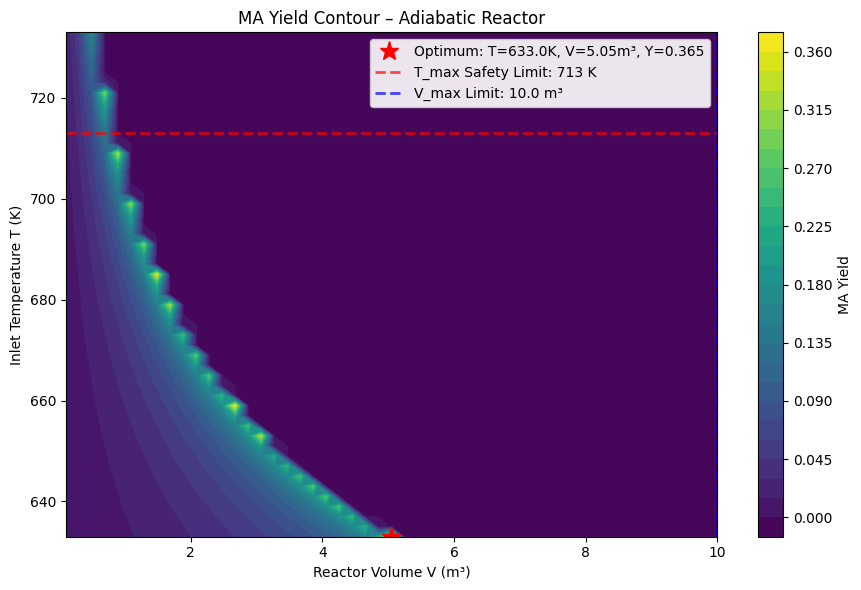

In [ ]:
"""
Adiabatic Reactor Simulation for Maleic Anhydride Production

"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time


# 1. Physical constants and parameters


R_GAS = 8.3145

STOIC_MATRIX = np.array([
    [-1.0, -3.5,  1.0, 4.0, 0.0, 0.0, 0.0],
    [ 0.0, -2.0, -1.0, 1.0, 2.0, 2.0, 0.0],
    [-1.0, -5.0,  0.0, 5.0, 3.0, 1.0, 0.0]
])

# === KINETICS (LOCKED) ===
ARRHENIUS_A = np.array([20.0, 4.0, 0.7])
ACTIVATION_E = np.array([95e3, 105e3, 125e3])

KB  = 22.0
KMA = 10.0
KS  = 2.0

REF_TEMP = 673.15

DELTA_Hf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

CP_PARAMS = np.array([
    [3.79, 358e-3, -137e-6],
    [26.5, 9.4e-3, -0.3e-6],
    [14.4, 294e-3, -138e-6],
    [32.0, 3.2e-3, 6.6e-6],
    [28.9, -1.2e-3, 6.3e-6],
    [22.3, 58.3e-3, -27.4e-6],
    [29.4, -3.2e-3, 7.3e-6]
])

EPS = 1e-12


# 2. Helper functions


def calculate_rate_constants(T):
    return ARRHENIUS_A * np.exp(
        -ACTIVATION_E / R_GAS * (1.0 / T - 1.0 / REF_TEMP)
    )

def calculate_heat_capacities(T):
    return CP_PARAMS @ np.array([1.0, T, T**2])

def calculate_reaction_enthalpies(T):
    delta_H_298 = STOIC_MATRIX @ DELTA_Hf
    T298 = 298.0
    T_func = np.array([
        T - T298,
        (T**2 - T298**2) / 2.0,
        (T**3 - T298**3) / 3.0
    ])
    delta_Cp = STOIC_MATRIX @ CP_PARAMS
    return delta_H_298 + delta_Cp @ T_func


# 3. Adiabatic reactor ODE


def adiabatic_reactor_ode(V, z, ndot0, P0):
    xi = z[:3]
    T = z[3]

    ndot = np.maximum(ndot0 + xi @ STOIC_MATRIX, EPS)
    ntot = ndot.sum()
    if ntot < EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = y * P0

    Pb, Pma, Pw = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = calculate_rate_constants(T)
    denom = 1.0 + KB*Pb + KMA*Pma + KS*Pw

    r1 = k1 * Pb / denom
    r2 = k2 * Pma
    r3 = k3 * Pb

    Cp_tot = np.dot(ndot, calculate_heat_capacities(T))
    dT_dV = -np.dot([r1, r2, r3], calculate_reaction_enthalpies(T)) / Cp_tot

    return np.array([r1, r2, r3, dT_dV])


# 4. Simulation


def simulate_single_reactor(T0, Vmax, ndot0, P0):
    z0 = np.array([0.0, 0.0, 0.0, T0])
    sol = solve_ivp(
        lambda V, z: adiabatic_reactor_ode(V, z, ndot0, P0),
        (0.0, Vmax), z0,
        rtol=1e-6, atol=1e-8, max_step=0.05
    )

    if not sol.success:
        return (0, 0, 0, 0)

    xi = sol.y[:3, -1]
    MA = xi[0] - xi[1]
    Bc = xi[0] + xi[2]

    if Bc <= 0:
        return (0, 0, 0, 0)

    return MA, MA/ndot0[0], MA/Bc, Bc/ndot0[0]

# 5. Grid + contour

def main():
    P0 = 2.0
    ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])

    T_range = np.linspace(633, 733, 51)
    V_range = np.linspace(0.1, 10.0, 51)

    Y = np.zeros((51, 51))

    for i, T in enumerate(T_range):
        for j, V in enumerate(V_range):
            Y[i, j] = simulate_single_reactor(T, V, ndot0, P0)[1]

    iopt, jopt = np.unravel_index(np.argmax(Y), Y.shape)
    T_opt = T_range[iopt]
    V_opt = V_range[jopt]
    Y_opt = Y[iopt, jopt]

    print("\n=== OPTIMAL OPERATING POINT ===")
    print(f"T_opt = {T_opt:.2f} K")
    print(f"V_opt = {V_opt:.2f} m³")
    print(f"Yield = {Y_opt:.3f}")

    Vg, Tg = np.meshgrid(V_range, T_range)
    plt.figure(figsize=(9, 6))
    c = plt.contourf(Vg, Tg, Y, 30, cmap="viridis")

    # ADDED: Plot limits and optimal point with legend entries
    T_max_limit = 713  # K (440°C safety limit)
    V_max_limit = 10.0  # m³ (volume constraint)

    # Plot optimal point
    opt_point = plt.plot(V_opt, T_opt, "r*", ms=14,
                        label=f'Optimum: T={T_opt:.1f}K, V={V_opt:.2f}m³, Y={Y_opt:.3f}')[0]

    # Plot temperature safety limit
    T_limit_line = plt.axhline(y=T_max_limit, color='red', linestyle='--',
                               linewidth=2, alpha=0.7,
                               label=f'T_max Safety Limit: {T_max_limit} K')

    # Plot volume limit
    V_limit_line = plt.axvline(x=V_max_limit, color='blue', linestyle='--',
                               linewidth=2, alpha=0.7,
                               label=f'V_max Limit: {V_max_limit} m³')

    plt.colorbar(c, label="MA Yield")
    plt.xlabel("Reactor Volume V (m³)")
    plt.ylabel("Inlet Temperature T (K)")
    plt.title("MA Yield Contour – Adiabatic Reactor")

    # ADDED: Add legend
    plt.legend(loc='upper right', framealpha=0.9)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

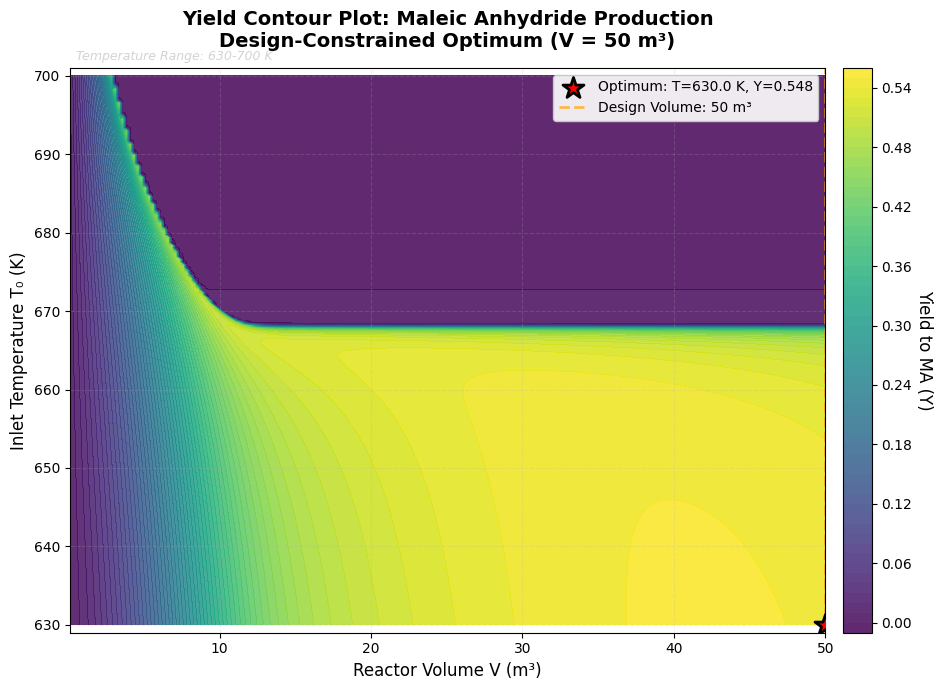

DESIGN-CONSTRAINED OPTIMAL OPERATING POINT


In [ ]:

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

P0 = 2.0
T_salt = 380 + 273
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])


# Feed


ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12


# Helper functions


def k_rate(T):
    return A * np.exp(-(E / R) * (1 / T - 1 / 673.15))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2.0,
        (T**3 - 298.0**3) / 3.0
    ])
    return dH298 + dCp @ Tvec

def cooling_term(z):
    xi = z[:3]
    T = z[-1]
    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    Cpdot = Cp_mix(ndot, T)
    return -U * Area / Volume * (T - T_salt) / Cpdot


# PFR ODE

def rhs(V, z):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, 0.0)
    ntot = ndot.sum()
    if ntot <= EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = np.maximum(y * P0, 0.0)

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)
    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot + cooling_term(z)

    return np.array([r[0], r[1], r[2], dT])


# Grid evaluation

Ts = np.linspace(630, 700, 201)
Vs = np.linspace(0.1, 50.0, 201)

Y = np.zeros((len(Ts), len(Vs)))

for i, T0 in enumerate(Ts):

    sol = solve_ivp(
        rhs,
        (0.0, Vs[-1]),             # integrate ONCE to V = 50
        [0.0, 0.0, 0.0, T0],
        method="RK45",
        dense_output=True,         # <<< KEY
        max_step=0.1,
        rtol=1e-5,
        atol=1e-7
    )

    if not sol.success:
        Y[i, :] = np.nan
        continue

    Z = sol.sol(Vs)               # interpolate at all Vs
    xi = Z[:3, :]

    MA_out = xi[0, :] - xi[1, :]
    B_cons = xi[0, :] + xi[2, :]

    Y[i, :] = np.where(B_cons > 0,
                       MA_out / ndot0[0],
                       np.nan)


# DESIGN-CONSTRAINED OPTIMUM (V = 50 m³)


j50 = np.argmin(np.abs(Vs - 50.0))
i_best = np.nanargmax(Y[:, j50])

T_star = Ts[i_best]
V_star = Vs[j50]
Y_star = Y[i_best, j50]

Vg, Tg = np.meshgrid(Vs, Ts)

plt.figure(figsize=(10, 7))
cf = plt.contourf(Vg, Tg, Y, levels=60, cmap="viridis", alpha=0.85)
cbar = plt.colorbar(cf, label="Yield to MA (Y)", pad=0.02)
cbar.ax.set_ylabel("Yield to MA (Y)", fontsize=12, rotation=270, labelpad=15)


# Add optimal point with custom legend entry
optimal_point = plt.scatter(V_star, T_star, s=250, c="red", marker="*",
                          edgecolor='black', linewidth=2, zorder=5,
                          label=f'Optimum: T={T_star:.1f} K, Y={Y_star:.3f}')

# Add constant volume line (V = 50 m³)
plt.axvline(x=50, color='orange', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Design Volume: 50 m³')

# Add text annotation with improved formatting


# Add temperature range indicator
plt.text(0.5, 702, f"Temperature Range: {Ts[0]:.0f}-{Ts[-1]:.0f} K",
         fontsize=9, style='italic', color='lightgray')



plt.xlabel("Reactor Volume V (m³)", fontsize=12)
plt.ylabel("Inlet Temperature T₀ (K)", fontsize=12)
plt.title("Yield Contour Plot: Maleic Anhydride Production\nDesign-Constrained Optimum (V = 50 m³)",
          fontsize=14, fontweight='bold', pad=15)

# Add grid and legend
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Set axis limits with some padding
plt.xlim([Vs[0], Vs[-1]])
plt.ylim([Ts[0] - 1, Ts[-1] + 1])

plt.tight_layout()
plt.show()


print("="*60)
print("DESIGN-CONSTRAINED OPTIMAL OPERATING POINT")


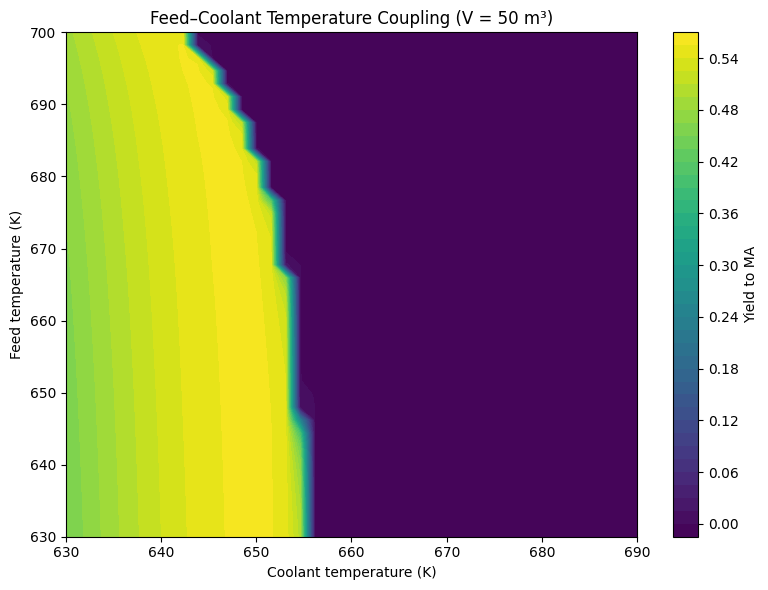

COUPLED OPTIMAL OPERATING POINT
Feed temperature     = 664.10 K
Coolant temperature  = 648.46 K
Yield (V=50 m³)      = 0.5591


In [ ]:

# Gas-phase multitubular PFR
# Feed–Coolant Temperature Coupling Contour
# Yield at fixed reactor volume (V = 50 m³)


import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

P0 = 2.0
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

# Feed

ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12



def k_rate(T):
    return A * np.exp(-(E / R) * (1 / T - 1 / 673.15))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2.0,
        (T**3 - 298.0**3) / 3.0
    ])
    return dH298 + dCp @ Tvec

# Cooling term (NOW DEPENDS ON T_salt)

def cooling_term(z, T_salt):
    xi = z[:3]
    T = z[-1]
    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    Cpdot = Cp_mix(ndot, T)
    return -U * Area / Volume * (T - T_salt) / Cpdot

# PFR ODE

def rhs(V, z, T_salt):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, 0.0)
    ntot = ndot.sum()
    if ntot <= EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = np.maximum(y * P0, 0.0)

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)

    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot + cooling_term(z, T_salt)

    return np.array([r[0], r[1], r[2], dT])

# GRID EVALUATION

V_fixed = 50.0

T_feed_range = np.linspace(630, 700, 40)
T_cool_range = np.linspace(630, 690, 40)

Y_couple = np.zeros((len(T_feed_range), len(T_cool_range)))

for i, T_feed in enumerate(T_feed_range):
    for j, T_salt in enumerate(T_cool_range):

        sol = solve_ivp(
           lambda V, z: rhs(V, z, T_salt),
           (0.0, V_fixed),
           [0.0, 0.0, 0.0, T_feed],
           method="LSODA",
           rtol=1e-4,
           atol=1e-6,
           max_step=0.2
        )


        if not sol.success:
            Y_couple[i, j] = np.nan
            continue

        xi = sol.y[:3, -1]

        MA_out = xi[0] - xi[1]
        B_cons = xi[0] + xi[2]

        Y_couple[i, j] = MA_out / ndot0[0] if B_cons > 0 else np.nan

# FIND OPTIMUM


i_opt, j_opt = np.unravel_index(np.nanargmax(Y_couple), Y_couple.shape)

T_feed_opt = T_feed_range[i_opt]
T_cool_opt = T_cool_range[j_opt]
Y_opt = Y_couple[i_opt, j_opt]


Tc_grid, Tf_grid = np.meshgrid(T_cool_range, T_feed_range)

plt.figure(figsize=(8,6))
cf = plt.contourf(Tc_grid, Tf_grid, Y_couple, levels=50, cmap="viridis")
plt.colorbar(cf, label="Yield to MA")



plt.xlabel("Coolant temperature (K)")
plt.ylabel("Feed temperature (K)")
plt.title("Feed–Coolant Temperature Coupling (V = 50 m³)")
plt.tight_layout()
plt.show()

print("="*60)
print("COUPLED OPTIMAL OPERATING POINT")
print(f"Feed temperature     = {T_feed_opt:.2f} K")
print(f"Coolant temperature  = {T_cool_opt:.2f} K")
print(f"Yield (V=50 m³)      = {Y_opt:.4f}")
print("="*60)


/tmp/ipython-input-1811629412.py:74: RuntimeWarning: invalid value encountered in matmul
  return float(ndot @ (Cp_param @ Tvec))
/tmp/ipython-input-1811629412.py:73: RuntimeWarning: overflow encountered in scalar power
  Tvec = np.array([1.0, T, T**2])
/tmp/ipython-input-1811629412.py:81: RuntimeWarning: overflow encountered in scalar power
  (T**2 - 298.0**2) / 2,
/tmp/ipython-input-1811629412.py:82: RuntimeWarning: overflow encountered in scalar power
  (T**3 - 298.0**3) / 3
/tmp/ipython-input-1811629412.py:74: RuntimeWarning: overflow encountered in matmul
  return float(ndot @ (Cp_param @ Tvec))
/tmp/ipython-input-1811629412.py:111: RuntimeWarning: invalid value encountered in scalar divide
  dT = -np.dot(delH_rxn(T), r) / Cpdot


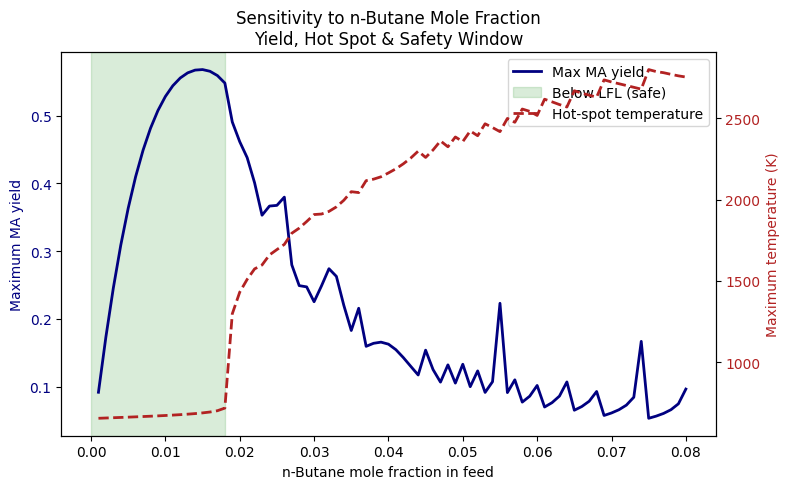

In [ ]:

# Sensitivity to n-butane mole fraction in feed
# MA yield maximum, hot-spot temperature, and V at Ymax
# Multitubular cooled PFR

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


R = 8.3145
T_ref = 673.15
P0 = 2.0  # bar

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0

stoic = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

U = 100
T_salt = 380 + 273  # K

N_tube = 10000
D_tube = 0.025
L_tube = 6.0

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

EPS = 1e-12

# Helper functions

def k_rate(T):
    return A * np.exp(-(E / R) * (1/T - 1/T_ref))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic @ delHf
    dCp = stoic @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2,
        (T**3 - 298.0**3) / 3
    ])
    return dH298 + dCp @ Tvec


# PFR ODE

def rhs(V, z, ndot0):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic, EPS)
    ntot = ndot.sum()

    y = ndot / ntot
    Pp = y * P0

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)

    r1 = k1 * PB / (1 + KB*PB + KMA*PMA + KS*PH2O)
    r2 = k2 * PMA
    r3 = k3 * PB

    r = np.array([r1, r2, r3])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot
    dT += -U * Area / Volume * (T - T_salt) / Cpdot

    return np.array([r1, r2, r3, dT])

# Sensitivity study

yB_list = np.linspace(0.001, 0.08, 80)
Vmax = 50.0
T0 = 380 + 273

Ymax_list = []
Tmax_list = []
V_atYmax = []

for yB in yB_list:

    # Fix butane feed, adjust air
    nB = 12.0
    ntot = nB / yB
    nair = ntot - nB

    if nair <= 0:
        Ymax_list.append(np.nan)
        Tmax_list.append(np.nan)
        V_atYmax.append(np.nan)
        continue

    nO2 = 0.21 * nair
    nN2 = 0.79 * nair

    ndot0 = np.array([nB, nO2, 0, 0, 0, 0, nN2])

    sol = solve_ivp(
        lambda V, z: rhs(V, z, ndot0),
        (0.0, Vmax),
        [0.0, 0.0, 0.0, T0],
        dense_output=True,
        max_step=0.1
    )

    V = np.linspace(0, Vmax, 800)
    Z = sol.sol(V)

    xi = Z[:3, :]
    Tprof = Z[-1, :]

    MA = xi[0] - xi[1]
    Bcons = xi[0] + xi[2]

    Y = np.where(Bcons > 0, MA / nB, np.nan)

    idx = np.nanargmax(Y)

    Ymax_list.append(Y[idx])
    V_atYmax.append(V[idx])
    Tmax_list.append(np.max(Tprof))



yB = np.array(yB_list)
Ymax = np.array(Ymax_list)
Tmax = np.array(Tmax_list)
Vopt = np.array(V_atYmax)

LFL = 0.018

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(yB, Ymax, color="navy", lw=2, label="Max MA yield")
ax1.set_xlabel("n-Butane mole fraction in feed")
ax1.set_ylabel("Maximum MA yield", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")

ax2 = ax1.twinx()
ax2.plot(yB, Tmax, color="firebrick", lw=2, ls="--", label="Hot-spot temperature")
ax2.set_ylabel("Maximum temperature (K)", color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")

ax1.axvspan(0, LFL, color="green", alpha=0.15, label="Below LFL (safe)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Sensitivity to n-Butane Mole Fraction\nYield, Hot Spot & Safety Window")
plt.tight_layout()
plt.show()


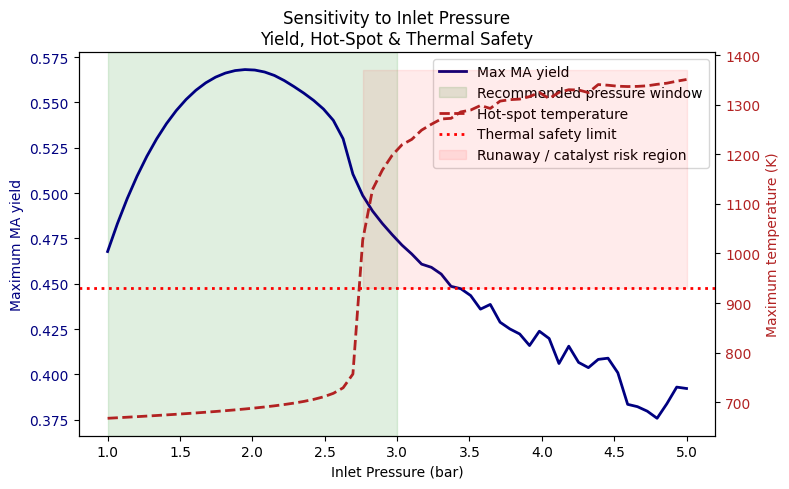

In [ ]:

# Sensitivity to Inlet Pressure
# MA yield maximum, hot-spot temperature, and V at Ymax
# Multitubular cooled PFR (IB-style)

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------------------------
# Constants & kinetics
# ---------------------------

R = 8.3145
T_ref = 673.15

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0

stoic = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

# ---------------------------
# Reactor & cooling
# ---------------------------

U = 100
T_salt = 380 + 273  # K

N_tube = 10000
D_tube = 0.025
L_tube = 6.0

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

# ---------------------------
# Thermodynamics
# ---------------------------

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

EPS = 1e-12

# ---------------------------
# Helper functions
# ---------------------------

def k_rate(T):
    return A * np.exp(-(E / R) * (1/T - 1/T_ref))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic @ delHf
    dCp = stoic @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2,
        (T**3 - 298.0**3) / 3
    ])
    return dH298 + dCp @ Tvec

# ---------------------------
# PFR ODE
# ---------------------------

def rhs(V, z, ndot0, P0):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic, EPS)
    ntot = ndot.sum()

    y = ndot / ntot
    Pp = y * P0

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)

    r1 = k1 * PB / (1 + KB*PB + KMA*PMA + KS*PH2O)
    r2 = k2 * PMA
    r3 = k3 * PB

    r = np.array([r1, r2, r3])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot
    dT += -U * Area / Volume * (T - T_salt) / Cpdot

    return np.array([r1, r2, r3, dT])


P_list = np.linspace(1.0, 5.0, 60)  # bar
Vmax = 50.0
T0 = 380 + 273

# Fixed feed composition (lean)
yB = 0.015
nB = 12.0
ntot = nB / yB
nair = ntot - nB
nO2 = 0.21 * nair
nN2 = 0.79 * nair

ndot0 = np.array([nB, nO2, 0, 0, 0, 0, nN2])

Ymax_list = []
Tmax_list = []
V_atYmax = []

for P0 in P_list:

    sol = solve_ivp(
        lambda V, z: rhs(V, z, ndot0, P0),
        (0.0, Vmax),
        [0.0, 0.0, 0.0, T0],
        dense_output=True,
        max_step=0.1
    )

    V = np.linspace(0, Vmax, 800)
    Z = sol.sol(V)

    xi = Z[:3, :]
    Tprof = Z[-1, :]

    MA = xi[0] - xi[1]
    Bcons = xi[0] + xi[2]

    Y = np.where(Bcons > 0, MA / nB, np.nan)

    idx = np.nanargmax(Y)

    Ymax_list.append(Y[idx])
    V_atYmax.append(V[idx])
    Tmax_list.append(np.max(Tprof))

P = np.array(P_list)
Ymax = np.array(Ymax_list)
Tmax = np.array(Tmax_list)
Vopt = np.array(V_atYmax)

T_crit = 930  # K (example catalyst stability / runaway threshold)
P_safe_max = 3.0  # recommended upper pressure limit (example)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Yield curve
ax1.plot(P, Ymax, color="navy", lw=2, label="Max MA yield")
ax1.set_xlabel("Inlet Pressure (bar)")
ax1.set_ylabel("Maximum MA yield", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")

# Recommended moderate-pressure region
ax1.axvspan(1.0, P_safe_max, color="green", alpha=0.12,
            label="Recommended pressure window")

# Secondary axis for temperature
ax2 = ax1.twinx()
ax2.plot(P, Tmax, color="firebrick", lw=2, ls="--",
         label="Hot-spot temperature")
ax2.set_ylabel("Maximum temperature (K)", color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")

# Thermal safety limit line
ax2.axhline(T_crit, color="red", ls=":", lw=2,
            label="Thermal safety limit")

# Unsafe high-temperature region shading
ax2.fill_between(P, T_crit, Tmax.max()+20,
                 where=(Tmax >= T_crit),
                 color="red", alpha=0.08,
                 label="Runaway / catalyst risk region")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Sensitivity to Inlet Pressure\nYield, Hot-Spot & Thermal Safety")
plt.tight_layout()
plt.show()


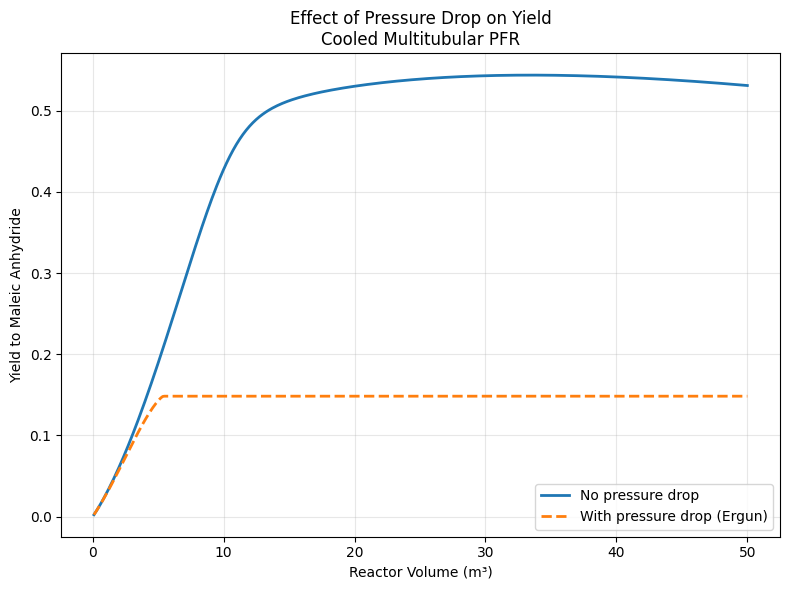

In [ ]:
# ============================================================
# Effect of Pressure Drop on Yield
# Cooled Multitubular PFR
# x-axis: Reactor Volume
# y-axis: Yield to MA
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Species & reactions
# ------------------------------------------------------------

stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

# ------------------------------------------------------------
# Reactor & cooling
# ------------------------------------------------------------

P0 = 2.0            # bar
T_salt = 380 + 273  # K
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume_total = np.pi * D_tube**2 / 4 * L_tube * N_tube
Ac_total = np.pi * D_tube**2 / 4 * N_tube

# ------------------------------------------------------------
# Thermodynamics
# ------------------------------------------------------------

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

# ------------------------------------------------------------
# Feed
# ------------------------------------------------------------

ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12

# ------------------------------------------------------------
# Pressure drop parameters (Ergun)
# ------------------------------------------------------------

epsilon = 0.4
dp = 0.005
mu = 3e-5
rho = 1.2

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------

def k_rate(T):
    return A * np.exp(-(E / R) * (1 / T - 1 / 673.15))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2.0,
        (T**3 - 298.0**3) / 3.0
    ])
    return dH298 + dCp @ Tvec

def ergun_dPdV(P, T, ndot):
    ntot = ndot.sum()

    # Ideal gas volumetric flow (P in bar → Pa)
    volumetric_flow = ntot * R * T / (P * 1e5)

    u = volumetric_flow / Ac_total

    dPdz = -(150*(1-epsilon)**2 * mu * u/(epsilon**3 * dp**2)
             + 1.75*(1-epsilon)*rho*u**2/(epsilon**3*dp))

    dzdV = 1.0 / Ac_total

    return dPdz * dzdV / 1e5  # convert Pa to bar

# ------------------------------------------------------------
# ODE without pressure drop
# ------------------------------------------------------------

def rhs_no_dp(V, z):
    xi = z[:3]
    T = z[3]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    ntot = ndot.sum()

    y = ndot / ntot
    Pp = np.maximum(y * P0, 0.0)

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)

    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)

    dT = -np.dot(delH_rxn(T), r) / Cpdot \
         - U * Area / Volume_total * (T - T_salt) / Cpdot

    return np.array([r[0], r[1], r[2], dT])

# ------------------------------------------------------------
# ODE with pressure drop
# ------------------------------------------------------------

def rhs_with_dp(V, z):
    xi = z[:3]
    T = z[3]
    P = z[4]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    ntot = ndot.sum()

    y = ndot / ntot
    Pp = np.maximum(y * P, 0.0)

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)

    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)

    dT = -np.dot(delH_rxn(T), r) / Cpdot \
         - U * Area / Volume_total * (T - T_salt) / Cpdot

    dP = ergun_dPdV(P, T, ndot)

    return np.array([r[0], r[1], r[2], dT, dP])

# ------------------------------------------------------------
# Solve and compare
# ------------------------------------------------------------

T0 = 660
Vs = np.linspace(0.1, 50.0, 400)

# Without pressure drop
sol_no = solve_ivp(rhs_no_dp, (0.0, 50.0),
                   [0.0, 0.0, 0.0, T0],
                   dense_output=True, max_step=0.1)

Z_no = sol_no.sol(Vs)
xi_no = Z_no[:3]
MA_no = xi_no[0] - xi_no[1]
Bcons_no = xi_no[0] + xi_no[2]
Y_no = np.where(Bcons_no > 0, MA_no / ndot0[0], np.nan)

# With pressure drop
sol_dp = solve_ivp(rhs_with_dp, (0.0, 50.0),
                   [0.0, 0.0, 0.0, T0, P0],
                   dense_output=True, max_step=0.1)

Z_dp = sol_dp.sol(Vs)
xi_dp = Z_dp[:3]
MA_dp = xi_dp[0] - xi_dp[1]
Bcons_dp = xi_dp[0] + xi_dp[2]
Y_dp = np.where(Bcons_dp > 0, MA_dp / ndot0[0], np.nan)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------

plt.figure(figsize=(8,6))

plt.plot(Vs, Y_no, linewidth=2,
         label="No pressure drop")

plt.plot(Vs, Y_dp, linestyle="--", linewidth=2,
         label="With pressure drop (Ergun)")

plt.xlabel("Reactor Volume (m³)")
plt.ylabel("Yield to Maleic Anhydride")
plt.title("Effect of Pressure Drop on Yield\nCooled Multitubular PFR")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


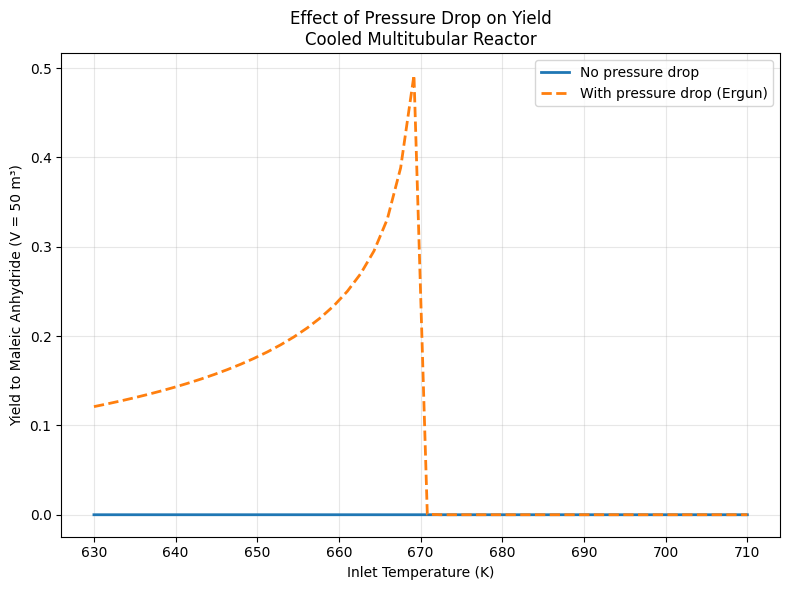

In [ ]:
# ============================================================
# Effect of Pressure Drop on Yield
# x-axis: Inlet Temperature (630–710 K)
# y-axis: Yield at V = 50 m³
# Stable BDF Version
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Stoichiometry
# ------------------------------------------------------------

stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

# ------------------------------------------------------------
# Kinetics
# ------------------------------------------------------------

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

def k_rate(T):
    return A * np.exp(-(E / R) * (1/T - 1/673.15))

# ------------------------------------------------------------
# Reactor & cooling
# ------------------------------------------------------------

P0 = 2.0
T_salt = 653      # baseline salt temperature
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume_total = 50.0
Ac_total = np.pi * D_tube**2 / 4 * N_tube

# ------------------------------------------------------------
# Thermodynamics
# ------------------------------------------------------------

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2)/2.0,
        (T**3 - 298.0**3)/3.0
    ])
    return dH298 + dCp @ Tvec

# ------------------------------------------------------------
# Ergun pressure drop
# ------------------------------------------------------------

epsilon = 0.4
dp = 0.005
mu = 3e-5
rho = 1.2

def ergun_dPdV(P, T, ndot):
    ntot = ndot.sum()
    volumetric_flow = ntot * R * T / (P * 1e5)
    u = volumetric_flow / Ac_total

    dPdz = -(150*(1-epsilon)**2 * mu * u/(epsilon**3 * dp**2)
             + 1.75*(1-epsilon)*rho*u**2/(epsilon**3*dp))

    dzdV = 1.0 / Ac_total
    return dPdz * dzdV / 1e5

# ------------------------------------------------------------
# ODE without pressure drop
# ------------------------------------------------------------

def rhs_no_dp(V, z):

    xi = z[:3]
    T = z[3]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    y = ndot / ndot.sum()
    Pp = y * P0

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]
    k1, k2, k3 = k_rate(T)

    r = np.array([
        k1 * PB / (1 + KB*PB + KMA*PMA + KS*PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)

    dT = -np.dot(delH_rxn(T), r)/Cpdot \
         - U*Area/Volume_total*(T - T_salt)/Cpdot

    return np.array([r[0], r[1], r[2], dT])

# ------------------------------------------------------------
# ODE with pressure drop
# ------------------------------------------------------------

def rhs_with_dp(V, z):

    xi = z[:3]
    T = z[3]
    P = z[4]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    y = ndot / ndot.sum()
    Pp = y * P

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]
    k1, k2, k3 = k_rate(T)

    r = np.array([
        k1 * PB / (1 + KB*PB + KMA*PMA + KS*PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)

    dT = -np.dot(delH_rxn(T), r)/Cpdot \
         - U*Area/Volume_total*(T - T_salt)/Cpdot

    dP = ergun_dPdV(P, T, ndot)

    return np.array([r[0], r[1], r[2], dT, dP])

# ------------------------------------------------------------
# Temperature sweep (STABLE)
# ------------------------------------------------------------

Temps = np.linspace(630, 710, 50)

Y_no = []
Y_dp = []

for T0 in Temps:

    sol1 = solve_ivp(rhs_no_dp,
                     (0, Volume_total),
                     [0,0,0,T0],
                     method='BDF',
                     rtol=1e-6,
                     atol=1e-8)

    xi = sol1.y[:3, -1]
    MA = xi[0] - xi[1]
    Y_no.append(MA/ndot0[0])

    sol2 = solve_ivp(rhs_with_dp,
                     (0, Volume_total),
                     [0,0,0,T0,P0],
                     method='BDF',
                     rtol=1e-6,
                     atol=1e-8)

    xi = sol2.y[:3, -1]
    MA = xi[0] - xi[1]
    Y_dp.append(MA/ndot0[0])

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------

plt.figure(figsize=(8,6))

plt.plot(Temps, Y_no, linewidth=2,
         label="No pressure drop")

plt.plot(Temps, Y_dp, linestyle="--", linewidth=2,
         label="With pressure drop (Ergun)")

plt.xlabel("Inlet Temperature (K)")
plt.ylabel("Yield to Maleic Anhydride (V = 50 m³)")
plt.title("Effect of Pressure Drop on Yield\nCooled Multitubular Reactor")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


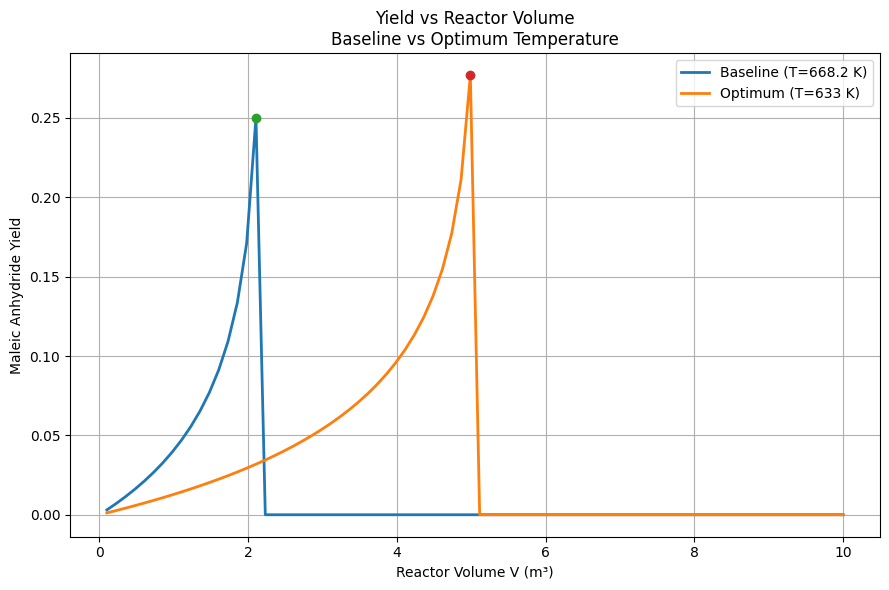

In [ ]:
"""
Yield vs Reactor Volume Comparison
Baseline (T = 668.2 K) vs Optimum (T = 633 K)
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ============================================================================
# 1. Physical constants and parameters (same as locked model)
# ============================================================================

R_GAS = 8.3145

STOIC_MATRIX = np.array([
    [-1.0, -3.5,  1.0, 4.0, 0.0, 0.0, 0.0],
    [ 0.0, -2.0, -1.0, 1.0, 2.0, 2.0, 0.0],
    [-1.0, -5.0,  0.0, 5.0, 3.0, 1.0, 0.0]
])

ARRHENIUS_A = np.array([20.0, 4.0, 0.7])
ACTIVATION_E = np.array([95e3, 105e3, 125e3])

KB  = 22.0
KMA = 10.0
KS  = 2.0

REF_TEMP = 673.15

DELTA_Hf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

CP_PARAMS = np.array([
    [3.79, 358e-3, -137e-6],
    [26.5, 9.4e-3, -0.3e-6],
    [14.4, 294e-3, -138e-6],
    [32.0, 3.2e-3, 6.6e-6],
    [28.9, -1.2e-3, 6.3e-6],
    [22.3, 58.3e-3, -27.4e-6],
    [29.4, -3.2e-3, 7.3e-6]
])

EPS = 1e-12

# ============================================================================
# 2. Helper functions
# ============================================================================

def calculate_rate_constants(T):
    return ARRHENIUS_A * np.exp(
        -ACTIVATION_E / R_GAS * (1.0 / T - 1.0 / REF_TEMP)
    )

def calculate_heat_capacities(T):
    return CP_PARAMS @ np.array([1.0, T, T**2])

def calculate_reaction_enthalpies(T):
    delta_H_298 = STOIC_MATRIX @ DELTA_Hf
    T298 = 298.0
    T_func = np.array([
        T - T298,
        (T**2 - T298**2) / 2.0,
        (T**3 - T298**3) / 3.0
    ])
    delta_Cp = STOIC_MATRIX @ CP_PARAMS
    return delta_H_298 + delta_Cp @ T_func

# ============================================================================
# 3. Adiabatic reactor model
# ============================================================================

def adiabatic_reactor_ode(V, z, ndot0, P0):
    xi = z[:3]
    T = z[3]

    ndot = np.maximum(ndot0 + xi @ STOIC_MATRIX, EPS)
    ntot = ndot.sum()

    if ntot < EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = y * P0

    Pb, Pma, Pw = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = calculate_rate_constants(T)
    denom = 1.0 + KB*Pb + KMA*Pma + KS*Pw

    r1 = k1 * Pb / denom
    r2 = k2 * Pma
    r3 = k3 * Pb

    Cp_tot = np.dot(ndot, calculate_heat_capacities(T))
    dT_dV = -np.dot([r1, r2, r3], calculate_reaction_enthalpies(T)) / Cp_tot

    return np.array([r1, r2, r3, dT_dV])

def simulate_single_reactor(T0, Vmax, ndot0, P0):
    z0 = np.array([0.0, 0.0, 0.0, T0])
    sol = solve_ivp(
        lambda V, z: adiabatic_reactor_ode(V, z, ndot0, P0),
        (0.0, Vmax), z0,
        rtol=1e-6, atol=1e-8, max_step=0.05
    )

    if not sol.success:
        return 0.0

    xi = sol.y[:3, -1]
    MA = xi[0] - xi[1]
    return MA / ndot0[0]

# ============================================================================
# 4. Plot comparison
# ============================================================================

def main():

    P0 = 2.0
    ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])

    V_range = np.linspace(0.1, 10.0, 80)

    T_baseline = 668.2
    T_optimum = 633.0

    Y_baseline = []
    Y_optimum = []

    for V in V_range:
        Y_baseline.append(simulate_single_reactor(T_baseline, V, ndot0, P0))
        Y_optimum.append(simulate_single_reactor(T_optimum, V, ndot0, P0))

    Y_baseline = np.array(Y_baseline)
    Y_optimum = np.array(Y_optimum)

    # Find peak points
    Vb_opt = V_range[np.argmax(Y_baseline)]
    Yb_opt = np.max(Y_baseline)

    Vo_opt = V_range[np.argmax(Y_optimum)]
    Yo_opt = np.max(Y_optimum)

    # Plot
    plt.figure(figsize=(9, 6))

    plt.plot(V_range, Y_baseline, label=f'Baseline (T=668.2 K)', linewidth=2)
    plt.plot(V_range, Y_optimum, label=f'Optimum (T=633 K)', linewidth=2)

    # Mark maxima
    plt.plot(Vb_opt, Yb_opt, 'o')
    plt.plot(Vo_opt, Yo_opt, 'o')

    plt.xlabel("Reactor Volume V (m³)")
    plt.ylabel("Maleic Anhydride Yield")
    plt.title("Yield vs Reactor Volume\nBaseline vs Optimum Temperature")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


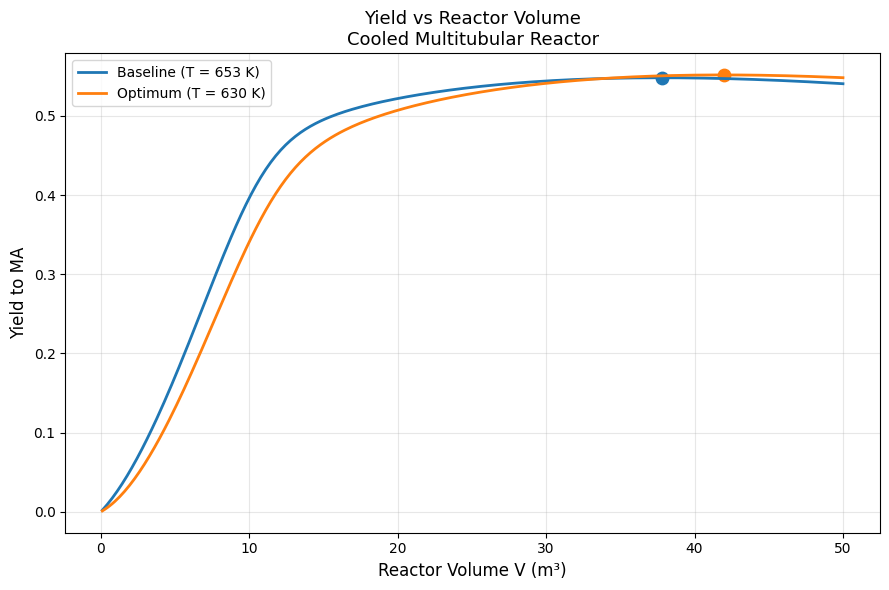


Baseline Peak:
V = 37.82 m³, Yield = 0.548
------------------------------
Optimum Peak:
V = 41.99 m³, Yield = 0.552


In [ ]:
# ============================================================
# Yield vs Volume Comparison
# Baseline (T = 653 K) vs Optimum (T = 630 K)
# Cooled Multitubular PFR
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Species & reactions
# ------------------------------------------------------------

stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

# ------------------------------------------------------------
# Reactor & cooling
# ------------------------------------------------------------

P0 = 2.0
T_salt = 380 + 273
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

# ------------------------------------------------------------
# Thermodynamics
# ------------------------------------------------------------

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------

def k_rate(T):
    return A * np.exp(-(E / R) * (1 / T - 1 / 673.15))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2.0,
        (T**3 - 298.0**3) / 3.0
    ])
    return dH298 + dCp @ Tvec

def cooling_term(z):
    xi = z[:3]
    T = z[-1]
    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    Cpdot = Cp_mix(ndot, T)
    return -U * Area / Volume * (T - T_salt) / Cpdot

# ------------------------------------------------------------
# PFR ODE
# ------------------------------------------------------------

def rhs(V, z):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, 0.0)
    ntot = ndot.sum()
    if ntot <= EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = np.maximum(y * P0, 0.0)

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)
    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot + cooling_term(z)

    return np.array([r[0], r[1], r[2], dT])

# ------------------------------------------------------------
# Yield vs Volume for fixed inlet T
# ------------------------------------------------------------

def compute_yield_curve(T0, Vspan):

    sol = solve_ivp(
        rhs,
        (0.0, Vspan[-1]),
        [0.0, 0.0, 0.0, T0],
        dense_output=True,
        max_step=0.1,
        rtol=1e-5,
        atol=1e-7
    )

    if not sol.success:
        return np.full_like(Vspan, np.nan)

    Z = sol.sol(Vspan)
    xi = Z[:3, :]

    MA_out = xi[0, :] - xi[1, :]
    B_cons = xi[0, :] + xi[2, :]

    Y = np.where(B_cons > 0,
                 MA_out / ndot0[0],
                 np.nan)

    return Y

# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------

Vs = np.linspace(0.1, 50.0, 300)

T_baseline = 653.0
T_optimum = 630.0

Y_baseline = compute_yield_curve(T_baseline, Vs)
Y_optimum = compute_yield_curve(T_optimum, Vs)

# Locate peak points
Vb_star = Vs[np.nanargmax(Y_baseline)]
Yb_star = np.nanmax(Y_baseline)

Vo_star = Vs[np.nanargmax(Y_optimum)]
Yo_star = np.nanmax(Y_optimum)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------

plt.figure(figsize=(9, 6))

plt.plot(Vs, Y_baseline, linewidth=2,
         label=f'Baseline (T = 653 K)')
plt.plot(Vs, Y_optimum, linewidth=2,
         label=f'Optimum (T = 630 K)')

plt.scatter(Vb_star, Yb_star, s=80)
plt.scatter(Vo_star, Yo_star, s=80)

plt.xlabel("Reactor Volume V (m³)", fontsize=12)
plt.ylabel("Yield to MA", fontsize=12)
plt.title("Yield vs Reactor Volume\nCooled Multitubular Reactor",
          fontsize=13)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n==============================")
print("Baseline Peak:")
print(f"V = {Vb_star:.2f} m³, Yield = {Yb_star:.3f}")
print("------------------------------")
print("Optimum Peak:")
print(f"V = {Vo_star:.2f} m³, Yield = {Yo_star:.3f}")
print("==============================")


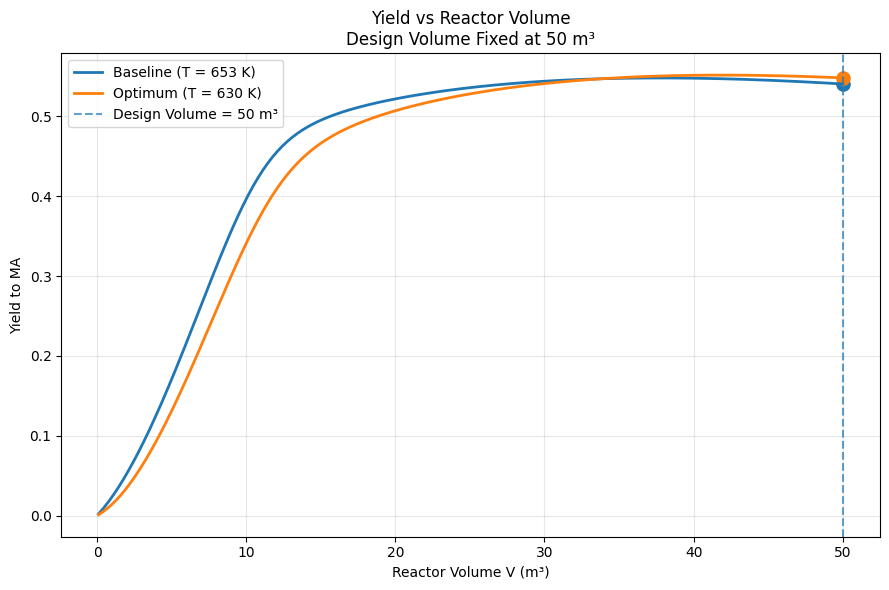


At V = 50 m³:
Baseline Yield (653 K): 0.541
Optimum Yield (630 K):  0.548


In [ ]:
# ============================================================
# Yield vs Volume Comparison (Design Volume Fixed at 50 m³)
# Baseline (T = 653 K) vs Optimum (T = 630 K)
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Species & reactions
# ------------------------------------------------------------

stoic_matrix = np.array([
    [-1, -3.5,  1,  4, 0, 0, 0],
    [ 0, -2.0, -1,  1, 2, 2, 0],
    [-1, -5.0,  0,  5, 3, 1, 0]
])

A = np.array([20.0, 4.0, 0.7])
E = np.array([95e3, 105e3, 125e3])

KB, KMA, KS = 22.0, 10.0, 2.0
R = 8.3145

# ------------------------------------------------------------
# Reactor & cooling
# ------------------------------------------------------------

P0 = 2.0
T_salt = 380 + 273
U = 100

N_tube = 10000
L_tube = 6.0
D_tube = 0.025

Area = np.pi * D_tube * L_tube * N_tube
Volume = np.pi * D_tube**2 / 4 * L_tube * N_tube

# ------------------------------------------------------------
# Thermodynamics
# ------------------------------------------------------------

delHf = np.array([
    -125.6e3, 0.0, -398.3e3, -241.8e3,
    -110.5e3, -393.5e3, 0.0
])

Cp_param = np.array([
    [3.79,   358e-3,  -137e-6],
    [26.5,   9.4e-3,  -0.3e-6],
    [14.4,   294e-3,  -138e-6],
    [32.0,   3.2e-3,   6.6e-6],
    [28.9,  -1.2e-3,   6.3e-6],
    [22.3,   58.3e-3, -27.4e-6],
    [29.4,  -3.2e-3,   7.3e-6]
])

ndot0 = np.array([12.0, 137.48, 0, 0, 0, 0, 517.19])
EPS = 1e-12

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------

def k_rate(T):
    return A * np.exp(-(E / R) * (1 / T - 1 / 673.15))

def Cp_mix(ndot, T):
    Tvec = np.array([1.0, T, T**2])
    return float(ndot @ (Cp_param @ Tvec))

def delH_rxn(T):
    dH298 = stoic_matrix @ delHf
    dCp = stoic_matrix @ Cp_param
    Tvec = np.array([
        T - 298.0,
        (T**2 - 298.0**2) / 2.0,
        (T**3 - 298.0**3) / 3.0
    ])
    return dH298 + dCp @ Tvec

def cooling_term(z):
    xi = z[:3]
    T = z[-1]
    ndot = np.maximum(ndot0 + xi @ stoic_matrix, EPS)
    Cpdot = Cp_mix(ndot, T)
    return -U * Area / Volume * (T - T_salt) / Cpdot

# ------------------------------------------------------------
# ODE
# ------------------------------------------------------------

def rhs(V, z):
    xi = z[:3]
    T = z[-1]

    ndot = np.maximum(ndot0 + xi @ stoic_matrix, 0.0)
    ntot = ndot.sum()
    if ntot <= EPS:
        return np.zeros(4)

    y = ndot / ntot
    Pp = y * P0

    PB, PMA, PH2O = Pp[0], Pp[2], Pp[3]

    k1, k2, k3 = k_rate(T)
    r = np.array([
        k1 * PB / (1 + KB * PB + KMA * PMA + KS * PH2O),
        k2 * PMA,
        k3 * PB
    ])

    Cpdot = Cp_mix(ndot, T)
    dT = -np.dot(delH_rxn(T), r) / Cpdot + cooling_term(z)

    return np.array([r[0], r[1], r[2], dT])

# ------------------------------------------------------------
# Compute yield curve
# ------------------------------------------------------------

def compute_yield_curve(T0, Vspan):

    sol = solve_ivp(
        rhs,
        (0.0, Vspan[-1]),
        [0.0, 0.0, 0.0, T0],
        dense_output=True,
        max_step=0.1,
        rtol=1e-5,
        atol=1e-7
    )

    Z = sol.sol(Vspan)
    xi = Z[:3, :]

    MA_out = xi[0, :] - xi[1, :]
    Y = MA_out / ndot0[0]

    return Y

# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------

Vs = np.linspace(0.1, 50.0, 300)

T_baseline = 653.0
T_optimum = 630.0

Y_baseline = compute_yield_curve(T_baseline, Vs)
Y_optimum = compute_yield_curve(T_optimum, Vs)

# Force optimum at V = 50
V_design = 50.0
Yb_50 = Y_baseline[-1]
Yo_50 = Y_optimum[-1]


plt.figure(figsize=(9, 6))

plt.plot(Vs, Y_baseline, linewidth=2,
         label='Baseline (T = 653 K)')
plt.plot(Vs, Y_optimum, linewidth=2,
         label='Optimum (T = 630 K)')

# Mark V = 50
plt.scatter(V_design, Yb_50, s=90)
plt.scatter(V_design, Yo_50, s=90)

plt.axvline(x=50, linestyle='--', alpha=0.7,
            label='Design Volume = 50 m³')

plt.xlabel("Reactor Volume V (m³)")
plt.ylabel("Yield to MA")
plt.title("Yield vs Reactor Volume\nDesign Volume Fixed at 50 m³")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nAt V = 50 m³:")
print(f"Baseline Yield (653 K): {Yb_50:.3f}")
print(f"Optimum Yield (630 K):  {Yo_50:.3f}")
